In [1]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.svm import SVR

## Data processing

In [2]:
## data loading ##

## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')
data_gdp = pd.read_csv('data_imf/thailand_gdp_imf.csv', delimiter=';')

data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})
data_gdp = data_gdp.rename(columns={'GDP (Billions of U.S. dollars)': 'gdp'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%d %H:%M:%S')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})
df.set_index('date', inplace=True)

# Calculate the minimum flowrate over the past week / month (base flowrate)
df['min_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).min()
df['min_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).min()

# add lag rainfall features
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)
df['rainfall_lag3'] = df['rainfall'].shift(3)
df['rainfall_lag5weeks'] = df['rainfall'].shift(35)
df['rainfall_week'] = df['rainfall'].rolling(window=7, min_periods=1).mean()
df['rainfall_total_week'] = df['rainfall'].rolling(window=7, min_periods=1).sum()

# extract DateTime components
df['year'] = df.index.year
df['month'] = df.index.month
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# merge with gdp data
df = pd.merge(df, data_gdp, on='year', how='left')

# scale data
scaler_rain = StandardScaler()
df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_total_week']] = scaler_rain.fit_transform(df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_total_week']])
scaler_flow = StandardScaler()
df[['flowrate']] = scaler_flow.fit_transform(df[['flowrate']])
scaler_statflow = StandardScaler()
df[['min_flow_week','min_flow_month']] = scaler_statflow.fit_transform(df[['min_flow_week','min_flow_month']])
scaler_gdp = StandardScaler()
df[['gdp']] = scaler_gdp.fit_transform(df[['gdp']])
scaler_time = StandardScaler()
df[['week_of_year']] = scaler_time.fit_transform(df[['week_of_year']])

In [3]:
# drop non-needed columns
df = df.drop(columns=['year', 'month', 'rainfall_week'])
# drop rows with missing values
df.dropna(inplace=True)

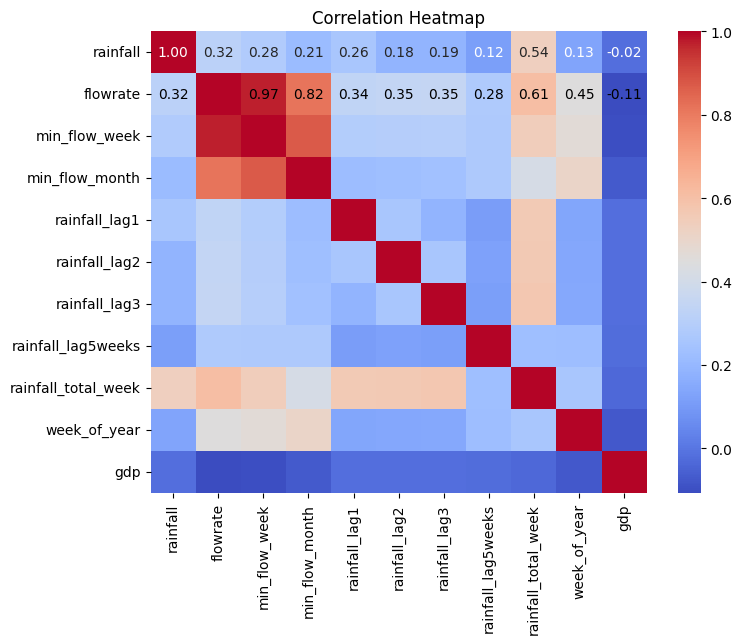

In [4]:
## heatmap ##
plt.figure(figsize=(8, 6))
corr = df.corr()

ax = sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Custom annotations for the "flowrate" row
for i in range(len(corr.columns)):
    if corr.index[i] == 'flowrate':
        for j in range(len(corr.columns)):
            if corr.columns[j] != 'flowrate':
                ax.text(j + 0.5, i + 0.5, f"{corr.iloc[i, j]:.2f}", 
                        color='black', ha='center', va='center')
plt.title('Correlation Heatmap')
plt.show()

## Models

In [5]:
# Define features and target variable
X = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_total_week']]
y = df['flowrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lasso_model = Lasso()

# Define the hyperparameter grid for Lasso
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(lasso_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Lasso Regression Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Lasso Regression Model
Mean Cross-Validation MSE: 0.5322 ± 0.0312
Mean Cross-Validation R²: 0.5065 ± 0.0208


In [6]:
# Define the Ridge regression model
ridge_model = Ridge()

# Create a pipeline with feature selection and Ridge regression
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(Lasso(random_state=42))),  # Placeholder, will be tuned
    ('ridge', ridge_model)
])

# Define the hyperparameter grid for both feature selection and Ridge regression
param_grid = {
    'feature_selection__estimator__alpha': [0.0001, 0.001, 0.01, 0.1],  # Lasso alpha values for feature selection
    'ridge__alpha': [0.0001, 0.001, 0.01, 0.1]  # Ridge alpha values
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Ridge Regression Model with Lasso Feature Selection")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Ridge Regression Model with Lasso Feature Selection
Mean Cross-Validation MSE: 0.5317 ± 0.0316
Mean Cross-Validation R²: 0.5070 ± 0.0216


In [7]:
## Bayesian Ridge Regression model
br_model = BayesianRidge()

# Create a pipeline with Lasso for feature selection and Bayesian Ridge Regression
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(Lasso(random_state=42))),  # Feature selection step
    ('bayesian_ridge', br_model)  # Bayesian Ridge Regression step
])

# Define the hyperparameter grid for Bayesian Ridge Regression
param_grid = {
    'feature_selection__estimator__alpha': [0.0001, 0.001, 0.01, 0.1],  # Lasso alpha values for feature selection
    'bayesian_ridge__max_iter': [50, 100, 150, 200, 250, 300],  # Number of iterations for the solver
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Bayesian Ridge Regression Model with Lasso Feature Selection")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Bayesian Ridge Regression Model with Lasso Feature Selection
Mean Cross-Validation MSE: 0.5317 ± 0.0316
Mean Cross-Validation R²: 0.5070 ± 0.0215


In [8]:
en_model = ElasticNet()

# Define the hyperparameter grid for ElasticNet regression
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],  # Regularization strength
    'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 1.0]  # Mix of L1 and L2 regularization
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(en_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("ElasticNet Regression Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

ElasticNet Regression Model
Mean Cross-Validation MSE: 0.5322 ± 0.0312
Mean Cross-Validation R²: 0.5065 ± 0.0208


In [9]:
dt_model = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 5, 6, 7, 8, 9, 10, 11],
    'min_samples_split': [10, 15, 16, 17, 18, 19, 20, 21],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'max_features': [None, 4, 5, 6, 7, 8, 9]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(dt_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Decision Tree Regressor Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Decision Tree Regressor Model
Mean Cross-Validation MSE: 0.2140 ± 0.0224
Mean Cross-Validation R²: 0.8020 ± 0.0152


In [10]:
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for RandomForest regression
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 4, 5, 6, 7, 8, 9]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(rf_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    print(best_model.get_params())
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Random Forest Regression Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf':

In [11]:
svr_model = SVR()

# Create a pipeline with Lasso for feature selection and SVR
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(Lasso(random_state=42))),  # Lasso feature selection
    ('svr', svr_model)  # SVR step
])

# Define the hyperparameter grid for SVR
param_grid = {
    'feature_selection__estimator__alpha': [0.0001, 0.001, 0.01, 0.1],  # Lasso alpha values for feature selection
    'svr__C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'svr__epsilon': [0.05, 0.1, 0.2, 0.5, 1],  # Epsilon parameter in the epsilon-SVR model
    'svr__kernel': ['linear', 'poly']  # Kernel type
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("SVR with Lasso Feature Selection Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

SVR with Lasso Feature Selection Model
Mean Cross-Validation MSE: 0.5361 ± 0.0317
Mean Cross-Validation R²: 0.5030 ± 0.0187


## Best model evaluated on test set

In [13]:
# Train the best model on the entire training set
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 4, 5, 6, 7, 8, 9]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the held-out test set
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print test set evaluation
print("\nRandom Forest Regression Model (Test Set Evaluation)")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Print the feature importances
feature_importances = best_model.feature_importances_
features = X.columns
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances = importances.sort_values('Importance', ascending=False)
print("\nFeature Importances:")
print(importances)


Random Forest Regression Model (Test Set Evaluation)
Test MSE: 0.3065
Test R-squared: 0.5383

Feature Importances:
               Feature  Importance
1         week_of_year    0.779473
6  rainfall_total_week    0.157493
3        rainfall_lag2    0.013738
5   rainfall_lag5weeks    0.013677
4        rainfall_lag3    0.012699
2        rainfall_lag1    0.011716
0             rainfall    0.011203


In [1]:
## plot results ##
plt.figure(figsize=(10, 6))
plt.plot(df.index, y, label='True', color='blue')
plt.plot(df.index[-len(y_test):], y_test_pred, label='Predicted', color='red')
plt.title('Random Forest Regression Model')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

NameError: name 'plt' is not defined